# Optimum Multi-Parameter Analysis

This notebook is intended to run an OMP analysis of the RU36 March 2022 dataset to investigate relative contributions of different source water types.


In [81]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import math
import xarray as xr
import dask.array as da
from erddapy import ERDDAP
import gsw
import sys
import pyompa



def get_erddap_dataset(ds_id, server, variables=None, constraints=None, filetype=None):
    """
    Returns a netcdf dataset for a specified dataset ID (or dataframe if dataset cannot be converted to xarray)
    :param ds_id: dataset ID e.g. ng314-20200806T2040
    :param variables: optional list of variables
    :param constraints: optional list of constraints
    :param filetype: optional filetype to return, 'nc' (default) or 'dataframe'
    :return: netcdf dataset
    """
    variables = variables or None
    constraints = constraints or None
    filetype = filetype or 'nc'
    #ioos_url = 'https://data.ioos.us/gliders/erddap'


    e = ERDDAP(server,
               protocol='tabledap',
               response='nc')
    e.dataset_id = ds_id
    if constraints:
        e.constraints = constraints
    if variables:
        e.variables = variables
    if filetype == 'nc':
        try:
            ds = e.to_xarray()
            ds = ds.sortby(ds.time)
        except OSError:
            print('No dataset available for specified constraints: {}'.format(ds_id))
            ds = []
        except TypeError:
            print('Cannot convert to xarray, providing dataframe: {}'.format(ds_id))
            ds = e.to_pandas().dropna()
    elif filetype == 'dataframe':
        #ds = e.to_pandas().dropna()
        ds = e.to_pandas().dropna(how='all')
    else:
        print('Unrecognized filetype: {}. Needs to  be "nc" or "dataframe"'.format(filetype))

    return ds


## Load in glider data

In [128]:
ds_id = 'ru36-20220223T1807-profile-sci-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'pressure','density','potential_temperature', 'salinity','oxygen_concentration','source_file']
sci_gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
sci_gdf.columns = variables

## Great way to find start and end times!!
start_times_sci = sci_gdf.groupby('source_file').first().time.values
end_times_sci   = sci_gdf.groupby('source_file').last().time.values

## Add a column of mass=1 for OMP function constraint
sci_gdf["mass"] = 1.0

## QUICK ROUGH QC ON OXYGEN DATA
sci_gdf.oxygen_concentration[sci_gdf.oxygen_concentration>300] = np.NaN
## Convert oxygen concentration from micromoles/L to ml/L
sci_gdf.oxygen_concentration = sci_gdf.oxygen_concentration/44.659

sci_gdf

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,depth,latitude,longitude,time,pressure,density,potential_temperature,salinity,oxygen_concentration,source_file,mass
0,0.104071,18.178870,-64.933555,2022-02-23T18:07:57.02Z,0.1047,1.023534e+03,2.625618e+01,3.576702e+01,4.542489,ru36-2022-053-3-0-dbd(00290000),1.0
1,NaN,18.178870,-64.933555,2022-02-23T18:07:57.06Z,NaN,9.969210e+36,9.969210e+36,9.969210e+36,NaN,ru36-2022-053-3-0-dbd(00290000),1.0
2,NaN,18.178869,-64.933557,2022-02-23T18:07:58.02Z,NaN,9.969210e+36,9.969210e+36,9.969210e+36,NaN,ru36-2022-053-3-0-dbd(00290000),1.0
3,0.149199,18.178868,-64.933560,2022-02-23T18:07:59.11Z,0.1501,1.023536e+03,2.625387e+01,3.576931e+01,NaN,ru36-2022-053-3-0-dbd(00290000),1.0
4,NaN,18.178867,-64.933563,2022-02-23T18:08:00.11Z,NaN,9.969210e+36,9.969210e+36,9.969210e+36,NaN,ru36-2022-053-3-0-dbd(00290000),1.0
...,...,...,...,...,...,...,...,...,...,...,...
4056473,NaN,18.145213,-64.805180,2022-03-16T23:54:00.38Z,NaN,9.969210e+36,9.969210e+36,9.969210e+36,NaN,ru36-2022-074-1-2-dbd(00490002),1.0
4056474,1.523496,18.145215,-64.805179,2022-03-16T23:54:01.38Z,1.5327,1.023488e+03,2.638805e+01,3.575444e+01,4.456974,ru36-2022-074-1-2-dbd(00490002),1.0
4056475,NaN,18.145215,-64.805179,2022-03-16T23:54:01.62Z,NaN,9.969210e+36,9.969210e+36,9.969210e+36,NaN,ru36-2022-074-1-2-dbd(00490002),1.0
4056476,1.326785,18.145216,-64.805178,2022-03-16T23:54:02.38Z,1.3348,1.023491e+03,2.637860e+01,3.575550e+01,NaN,ru36-2022-074-1-2-dbd(00490002),1.0


## Subset glider data to Subtropical Under-Water first

**Density Range:** 1024.5-1026.75 <br>
**Temperature Range:** 12-24

In [98]:
subset_sci_gdf = sci_gdf[(sci_gdf.density >= 1024.5) & (sci_gdf.density <= 1026.75)]
## Just a few points to make it quick
#subset_sci_gdf = subset_sci_gdf[0:20000]

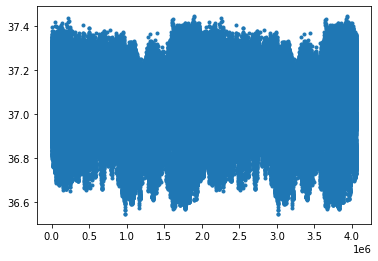

In [99]:
plt.plot(subset_sci_gdf.salinity,'.')


## Determine End-Members

In [134]:
#                                temp       sal         oxy
NAW_SUW =       ["NAW_SUW",       19,    36.75,        3.5]
SAW_SUW =       ["SAW_SUW",        17,     35.4,       4.1]
SETA_SUW =     ["SETA_SUW",      17,     36,       2.75]


def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "potential_temperature", "salinity", "oxygen_concentration"])
    df["mass"] = 1
    return df

subtropical_under_waters_FK_endmemberdf = prepare_endmember_df([NAW_SUW, SAW_SUW, SETA_SUW])
subtropical_under_waters_FK_endmemberdf

,endmember_name,potential_temperature,salinity,oxygen_concentration,mass
0,NAW_SUW,19,36.75,3.50,1
1,SAW_SUW,17,35.40,4.10,1
2,SETA_SUW,17,36.00,2.75,1


In [135]:
#Define a parameter to represent remineralization in terms of phosphate
# The ratio of oxygen:phosphate specified is -170:1, that is 170 moles of
# oxygen consumed for each mole of oxygen produced.
convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen_concentration": -170, "phosphate": 1.0}],
        always_positive=True #The MATLAB OMP implementation enforces a positive
        # value for the delta P variable, meaning it can only model
        # remineralization. Change to False (the default) to also model
        # assimilation.
        )
]


paramweightings = {
    "potential_temperature": 24.0,
    "salinity": 24.0,
    "mass": 24.0,
    "oxygen_concentration": 7.0,
}

settings = {
    "param_names": ["potential_temperature", "salinity",
                    "oxygen_concentration", "mass"],
    "convertedparam_groups": convertedparamgroups,
    "param_weightings": paramweightings,
}


#Run the analysis, replicating the MATLAB OMP analysis
ompa_soln = pyompa.OMPAProblem(
  obs_df = subset_sci_gdf,
  **settings).solve(
      subtropical_under_waters_FK_endmemberdf,
      endmember_name_column="endmember_name")

Dropping 155988 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1]), ('SETA', [2])])
params to use: ['potential_temperature', 'salinity', 'oxygen_concentration', 'mass']
param weighting: [24. 24.  7. 24.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 148790 out of 148790
status: optimal
optimal value 257536538426.398
Original weighted sum squares: 257536538426.398
Post fix weighted sum squared: 257536562222.27026
On example 0 to 148790 out of 148790
status: optimal
optimal value 257536538426.398
Original weighted sum squares: 257536538426.398
Post fix weighted sum squared: 257536562222.27026
objective: 257536562222.27017


In [136]:
# from matplotlib import pyplot as plt
# from pyompa import (plot_ompasoln_endmember_fractions,                       
#                     plot_ompasoln_residuals,                                 
#                     plot_ompasoln_endmember_usagepenalties)

# plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln, xaxis_colname="time", yaxis_colname="depth")

# #plot_ompasoln_residuals(ompa_soln=ompa_soln, xaxis_colname="longitude", yaxis_colname="depth")


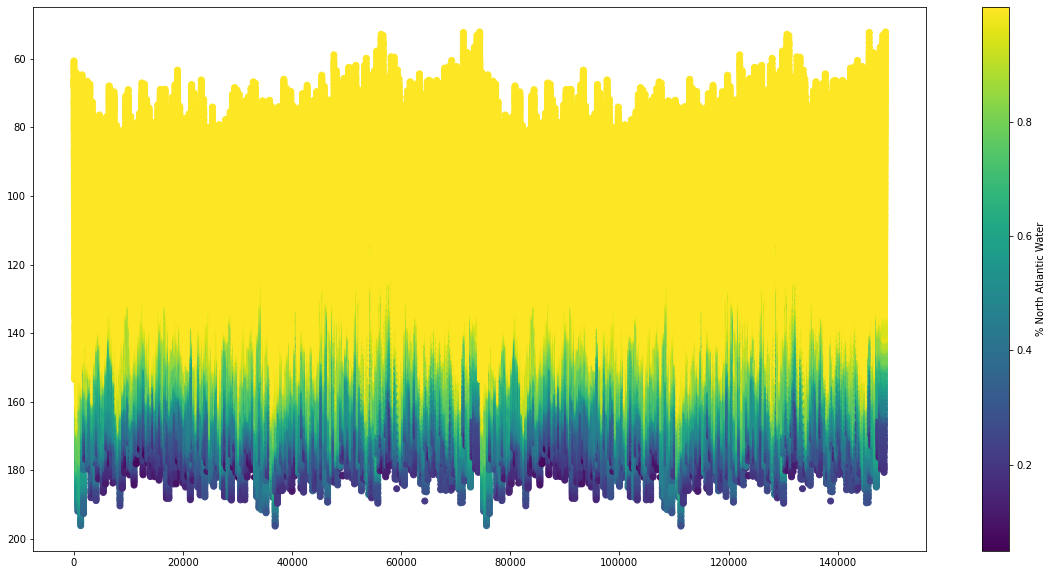

In [141]:
min_range = 0
max_range = 148790

plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), ompa_soln.obs_df.depth[min_range:max_range], c=ompa_soln.endmember_fractions[min_range:max_range,0])
plt.gca().invert_yaxis()
plt.colorbar(label='% North Atlantic Water')

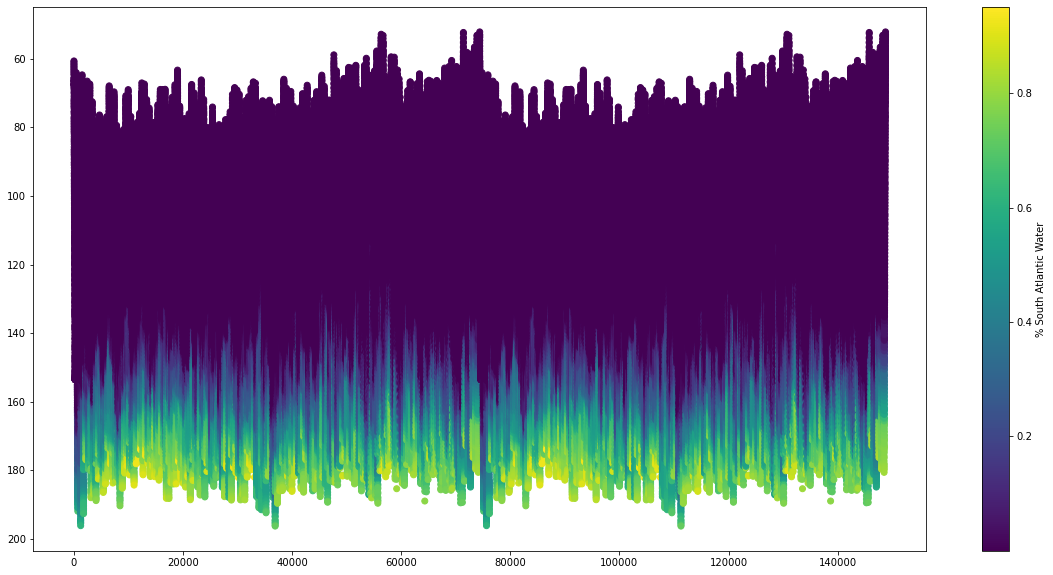

In [142]:
min_range = 0
max_range = 148790

plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), ompa_soln.obs_df.depth[min_range:max_range], c=ompa_soln.endmember_fractions[min_range:max_range,1])
plt.gca().invert_yaxis()
plt.colorbar(label='% South Atlantic Water')

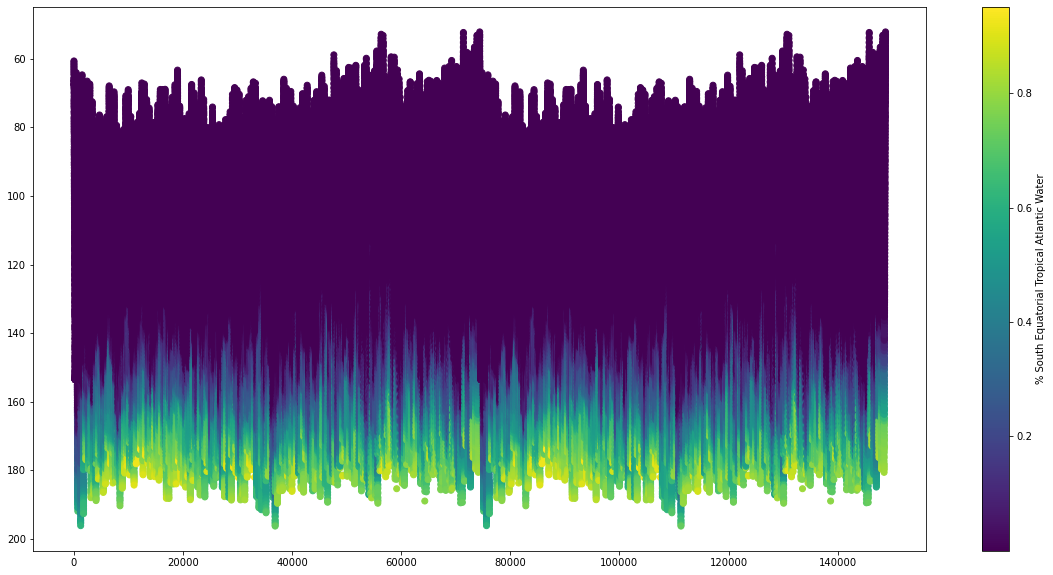

In [143]:
min_range = 0
max_range = 148790

plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), ompa_soln.obs_df.depth[min_range:max_range], c=ompa_soln.endmember_fractions[min_range:max_range,1])
plt.gca().invert_yaxis()
plt.colorbar(label='% South Equatorial Tropical Atlantic Water')

In [144]:
hardmasscons_settings = {
    "param_names": ["potential_temperature", "salinity",
                    "oxygen_concentration", "mass"],
    "param_weightings": paramweightings,
    "convertedparam_groups": convertedparamgroups,
    #The difference here is that sumtooneconstraint is True
    "sumtooneconstraint": True,
    "standardize_by_watertypes": True
}


#Run the analysis with the hard mass conservation constraint
hardmasscons_ompa_soln = pyompa.OMPAProblem(
  obs_df = subset_sci_gdf,
  **hardmasscons_settings).solve(
      subtropical_under_waters_FK_endmemberdf,
      endmember_name_column="endmember_name")

Dropping 155988 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1]), ('SETA', [2])])
I'm assuming that the index encoding mass is: [3]
Std used for normalization: [1.15470054 0.67638746 0.67638746 1.        ]
Mean used for normalization: [17.66666667 36.05        3.45        0.        ]
params to use: ['potential_temperature', 'salinity', 'oxygen_concentration', 'mass']
param weighting: [24. 24.  7. 24.]
effective weighting: [20.78460969 35.48262101 10.34909779 24.        ]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 148790 out of 148790
status: optimal
optimal value 557870235813.032
Original weighted sum squares: 557870235813.032
Post fix weighted sum squared: 557870327497.9822
On example 0 to 148790 out of 148790
status: optimal
optimal value 557870235813.032
Original weighted sum squares: 557870235813.032
Post fix weighted sum squared: 557870327497.9822
objective: 557870327497.9823


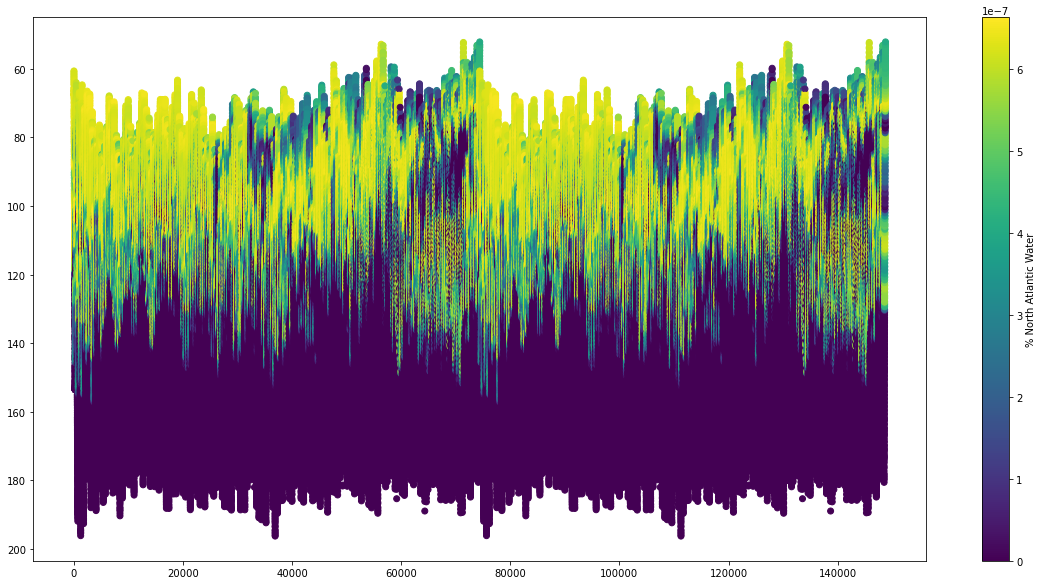

In [145]:
min_range = 0
max_range = 148790

plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), hardmasscons_ompa_soln.obs_df.depth[min_range:max_range], c=hardmasscons_ompa_soln.endmember_fractions[min_range:max_range,0])
plt.gca().invert_yaxis()
plt.colorbar(label='% North Atlantic Water')

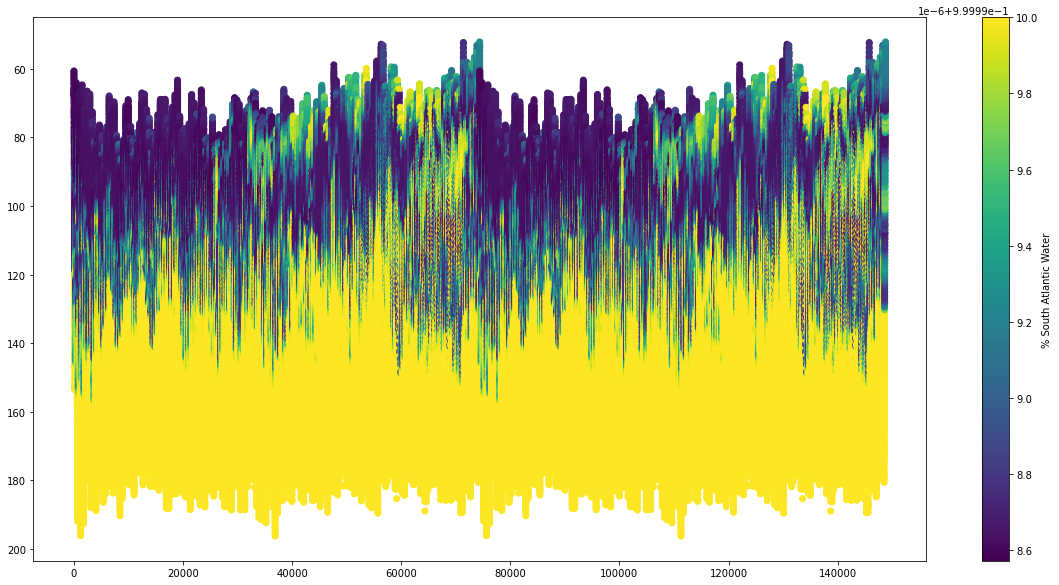

In [146]:
min_range = 0
max_range = 148790

plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), hardmasscons_ompa_soln.obs_df.depth[min_range:max_range], c=hardmasscons_ompa_soln.endmember_fractions[min_range:max_range,1])
plt.gca().invert_yaxis()
plt.colorbar(label='% South Atlantic Water')

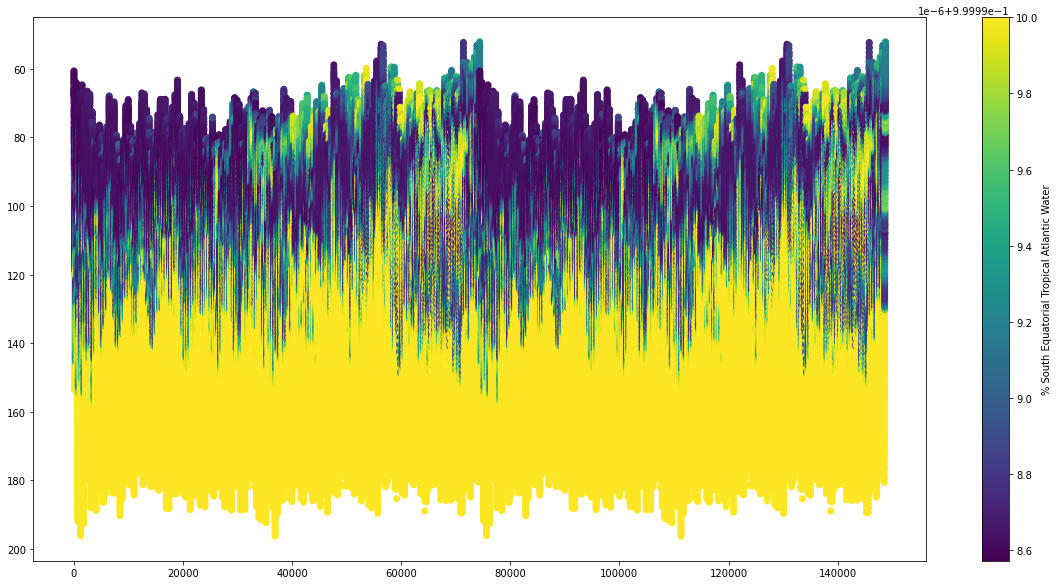

In [147]:
min_range = 0
max_range = 148790

plt.figure(figsize=(20,10))
plt.scatter(np.arange(min_range,max_range), hardmasscons_ompa_soln.obs_df.depth[min_range:max_range], c=hardmasscons_ompa_soln.endmember_fractions[min_range:max_range,1])
plt.gca().invert_yaxis()
plt.colorbar(label='% South Equatorial Tropical Atlantic Water')

In [151]:
NADW_ds = sci_gdf[sci_gdf.density>1027.6] 

plt.figure(figsize=(20,10))
plt.scatter(NADW_ds.time, NADW_ds.depth, c=NADW_ds.oxygen_concentration)
plt.gca().invert_yaxis()
plt.colorbar()

Error in callback <function flush_figures at 0x7fd6265e75f0> (for post_execute):


KeyboardInterrupt: 